## Custom CNN Model.

## Importing Libraries

In [25]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

## Declare Constants

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 11

## Load Dataset

In [3]:
train_df = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/train",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6225 files belonging to 11 classes.


In [4]:
class_names = train_df.class_names
class_names

['animal fish',
 'animal fish bass',
 'fish sea_food black_sea_sprat',
 'fish sea_food gilt_head_bream',
 'fish sea_food hourse_mackerel',
 'fish sea_food red_mullet',
 'fish sea_food red_sea_bream',
 'fish sea_food sea_bass',
 'fish sea_food shrimp',
 'fish sea_food striped_red_mullet',
 'fish sea_food trout']

In [5]:
len(train_df)

195

In [6]:
for image_batch,label_batch in train_df.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[8 3 0 5 6 4 2 5 6 5 3 8 5 8 9 6 4 5 5 5 0 7 5 6 5 2 2 0 0 9 5 2]


## Preview Of Images

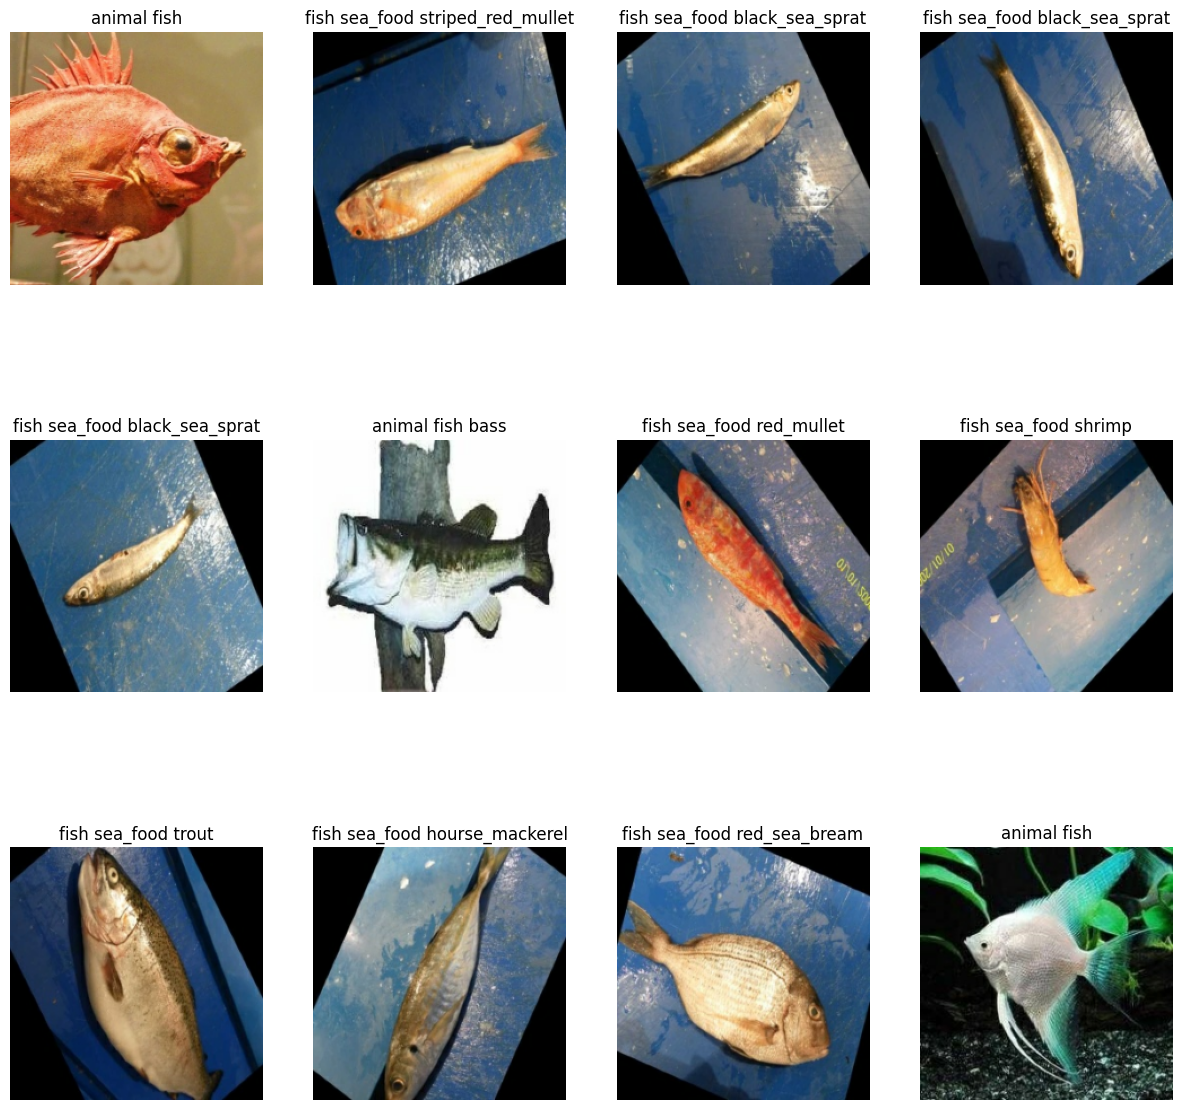

In [11]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in train_df.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

## Load Test Dataset

In [12]:
test_df = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/test",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3187 files belonging to 11 classes.


## Load Validation Dataset

In [13]:
validation_df = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/val",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1092 files belonging to 11 classes.


## 1. cache()
- Purpose: Caches the dataset in memory after the first epoch.
## 2. shuffle(1000)
- Purpose: Randomly shuffles the dataset.
## 3. prefetch(buffer_size=tf.data.AUTOTUNE)
- Purpose: Allows the pipeline to prepare the next batch while the current batch is being processed (asynchronously).

In [14]:
train_dataset = train_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_dataset = validation_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## Resizing and Rescaling Images

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [19]:
model =  models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(n_classes,activation='softmax')
])

## Build Model

In [20]:
model.build(input_shape = input_shape)

## Model Summary

In [21]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 52, 52, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 26, 26, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 24, 24, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (32, 12, 12, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (32, 10, 10, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (32, 5, 5, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 3, 3, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (32, 1, 1, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 11)               │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,819 (655.54 KB)

 Trainable params: 167,819 (655.54 KB)

 Non-trainable params: 0 (0.00 B)

## Compile The Model

In [22]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

## Train Model

In [24]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 88s 403ms/step - accuracy: 0.2032 - loss: 2.1881 - val_accuracy: 0.3883 - val_loss: 1.7747
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 75s 383ms/step - accuracy: 0.5171 - loss: 1.3292 - val_accuracy: 0.5952 - val_loss: 1.0384
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 396ms/step - accuracy: 0.7214 - loss: 0.7627 - val_accuracy: 0.8004 - val_loss: 0.5914
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 83s 424ms/step - accuracy: 0.7788 - loss: 0.5987 - val_accuracy: 0.8434 - val_loss: 0.4785
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 411ms/step - accuracy: 0.8408 - loss: 0.4292 - val_accuracy: 0.8800 - val_loss: 0.3829
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 415ms/step - accuracy: 0.8753 - loss: 0.3524 - val_accuracy: 0.9112 - val_loss: 0.2989
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 399ms/step - accuracy: 0.8885 - loss: 0.3136 - val_accuracy: 0.9386 - val_loss: 0.2186
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 75s 387ms/step - accuracy: 0.9100 - loss: 0

## Evaluating Model on test dataset

In [26]:
scores = model.evaluate(test_dataset)

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.9696 - loss: 0.0987


In [27]:
scores

[0.09866660833358765, 0.9695638418197632]

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 195}

In [30]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_ran = len(acc)

## Chart - Training vs Validation (Acurracy & Loss)

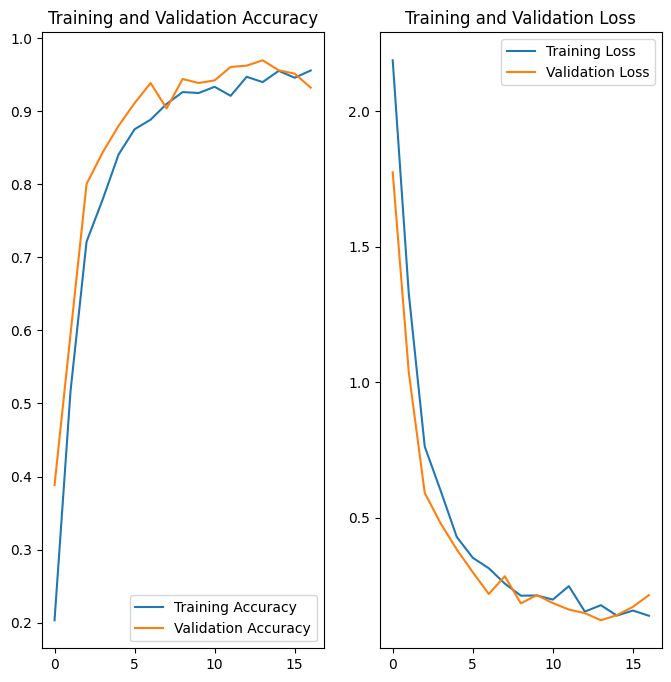

In [32]:
plt.figure(figsize=(8, 8))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs_ran), acc, label='Training Accuracy')
plt.plot(range(epochs_ran), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig('../results/metrices/Training_vs_Validation_Accuracy.png')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs_ran), loss, label='Training Loss')
plt.plot(range(epochs_ran), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('../results/metrices/Training_vs_Validation_Loss.png')

plt.show()

## Making prediction on single image from test dataset

first image to predict
actual label: fish sea_food striped_red_mullet
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
predicted label: fish sea_food striped_red_mullet


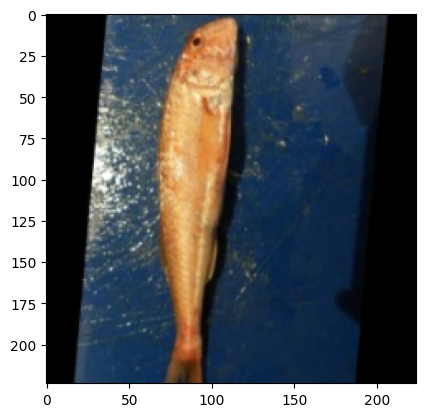

In [33]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Make Predictions

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Plot the predicted images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


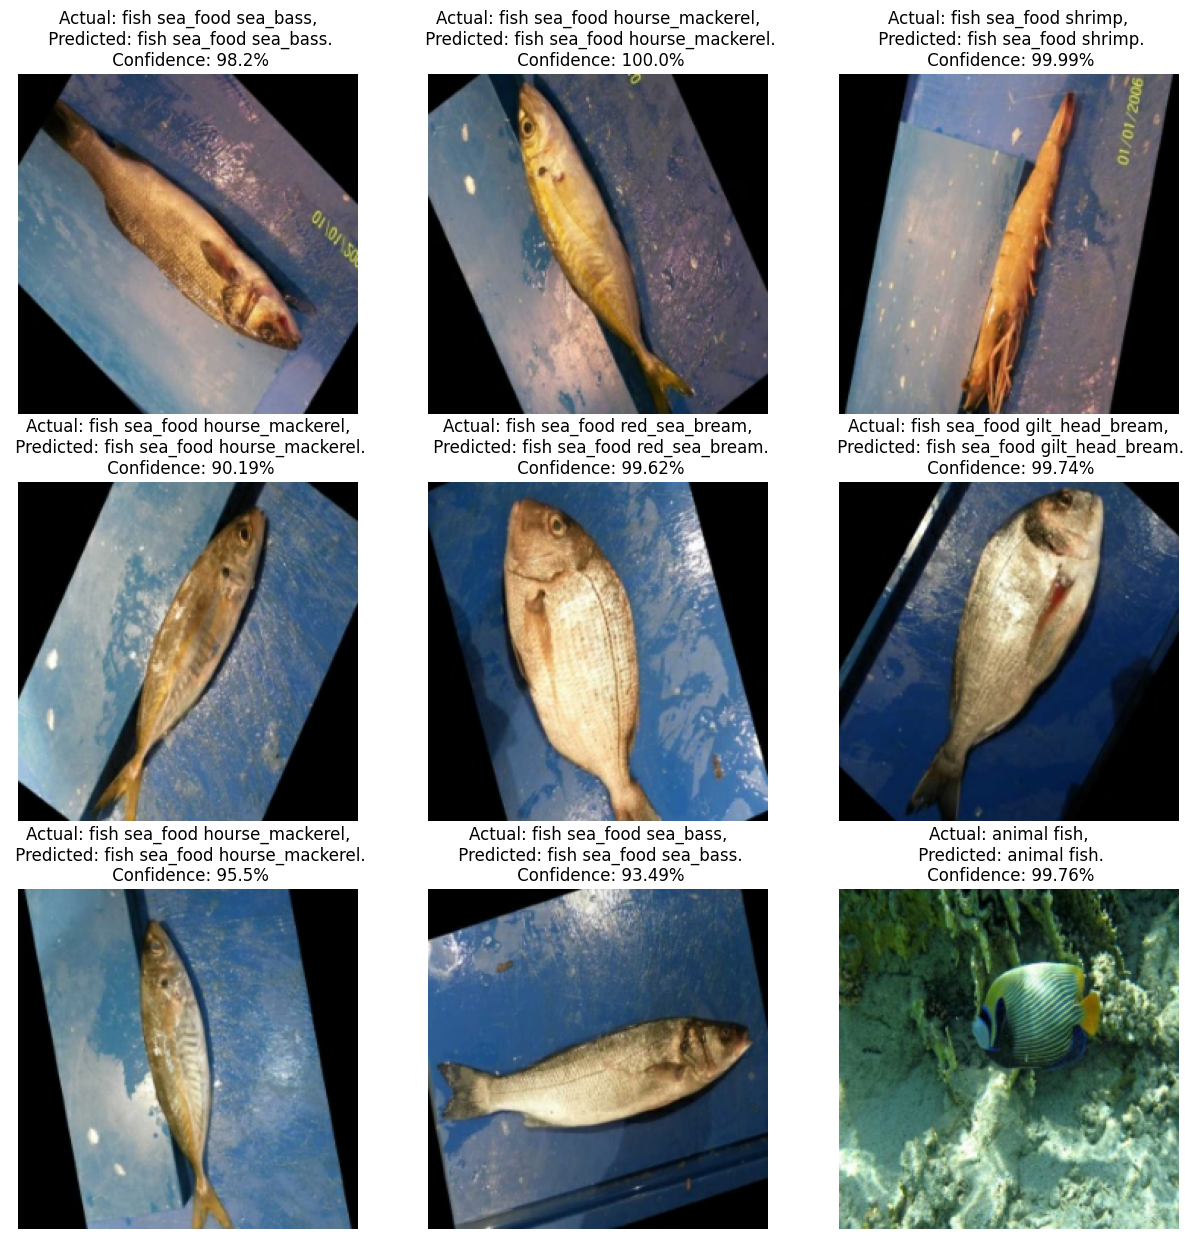

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Save model

In [36]:
model.save("../models/Custom_CNN_Fish_Classificatio.keras")

## Performance Metrices

In [37]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Accuracy:", test_accuracy)

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.9696 - loss: 0.0987
Test Accuracy: 0.9695638418197632


In [48]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [49]:
# Reload or use original dataset before prefetch
original_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/test",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

# Save class names before prefetching
class_names = original_test_dataset.class_names

# Now prefetch the dataset
test_dataset = original_test_dataset.prefetch(tf.data.AUTOTUNE)

Found 3187 files belonging to 11 classes.


In [50]:
from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

Confusion Matrix:
 [[513   0   0   0   0   1   1   1   0   0   4]
 [ 13   0   0   0   0   0   0   0   0   0   0]
 [  0   0 293   0   0   0   0   5   0   0   0]
 [  3   0   0 284   0   0  15   1   0   0   2]
 [  0   0   0   0 277   0   0   8   0   0   1]
 [  0   0   0   0   0 291   0   0   0   0   0]
 [  0   0   0   9   0   0 260   2   0   1   1]
 [  0   0   0   7   0   0   0 320   0   0   0]
 [  0   0   0   0   0   0   0   0 289   0   0]
 [  0   0   0   0   3   1   0  10   2 277   0]
 [  0   0   0   3   0   0   3   0   0   0 286]]
Classification Report:
                                   precision    recall  f1-score   support

                     animal fish       0.97      0.99      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       1.00      0.98      0.99       298
   fish sea_food gilt_head_bream       0.94      0.93      0.93       305
   fish sea_food hourse_mackerel       0.99      0.97      0.98     

c:\Users\sumit\OneDrive\Desktop\Multiclass Fish Image Classification\.fish-env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sumit\OneDrive\Desktop\Multiclass Fish Image Classification\.fish-env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sumit\OneDrive\Desktop\Multiclass Fish Image Classification\.fish-env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

In [51]:
# Load test dataset (without prefetching)
test_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/test",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

# Extract class names before applying .prefetch()
class_names = test_dataset_raw.class_names

# Now prefetch the dataset (optional for performance)
test_dataset = test_dataset_raw.prefetch(tf.data.AUTOTUNE)

Found 3187 files belonging to 11 classes.


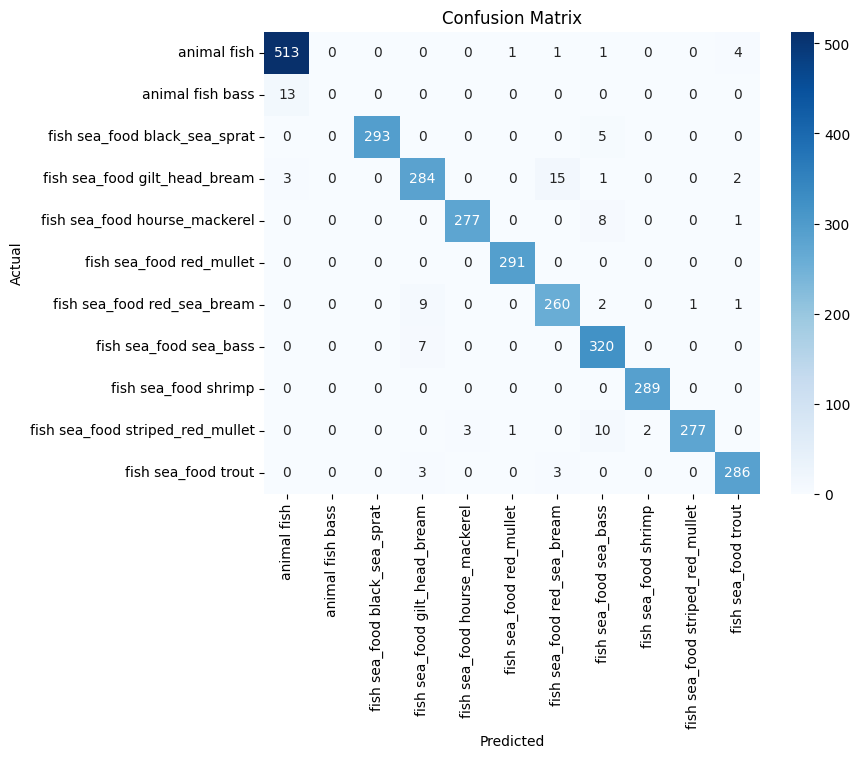

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,  # Use saved list
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [53]:
import numpy as np

y_true = []
y_pred_probs = []

for images, labels in test_dataset:
    probs = model.predict(images)  # shape (batch_size, num_classes)
    y_pred_probs.extend(probs)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [39]:
n_classes = y_pred_probs.shape[1]
y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))

In [47]:
# Load test dataset (without prefetching)
test_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/test",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

# Extract class names before applying .prefetch()
class_names = test_dataset_raw.class_names

# Now prefetch the dataset (optional for performance)
test_dataset = test_dataset_raw.prefetch(tf.data.AUTOTUNE)

Found 3187 files belonging to 11 classes.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,  # Use saved list
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## ROC-AUC Curve (Multiclass OvR)

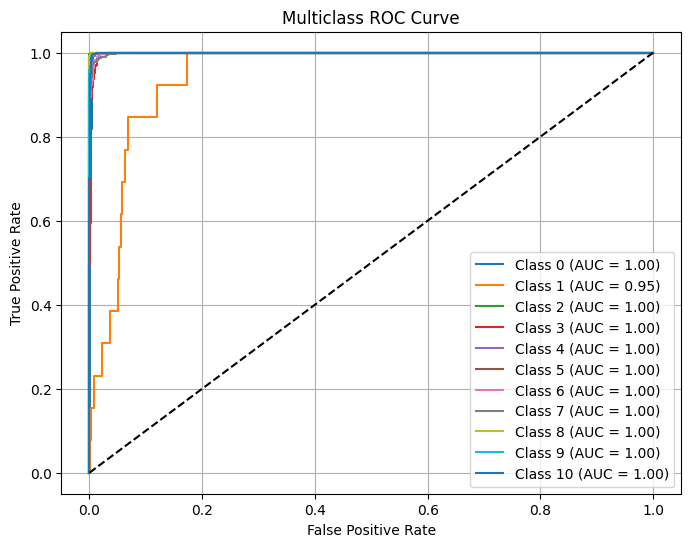

In [40]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig("../results/metrices/Custom_CNN_roc_curve.png")
plt.show()

## Precision-Recall Curve

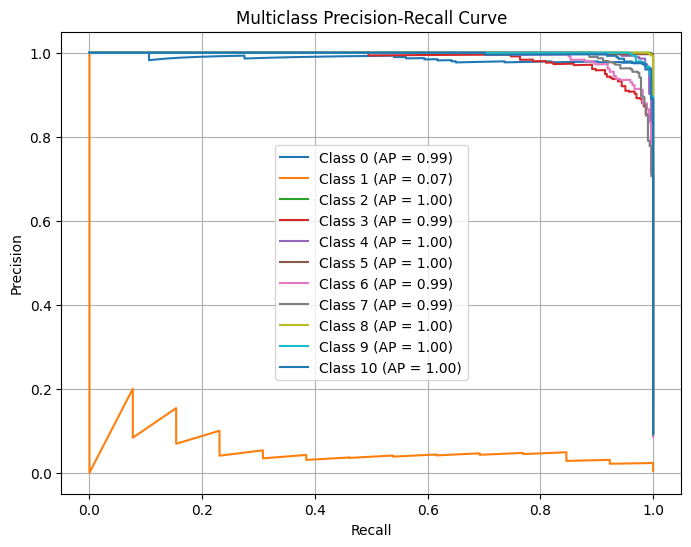

In [41]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_true_binarized[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.savefig("../results/metrices/Custom_CNN_precision_recall_curve.png")  
plt.show()

## F1-score vs. Threshold (for one class)

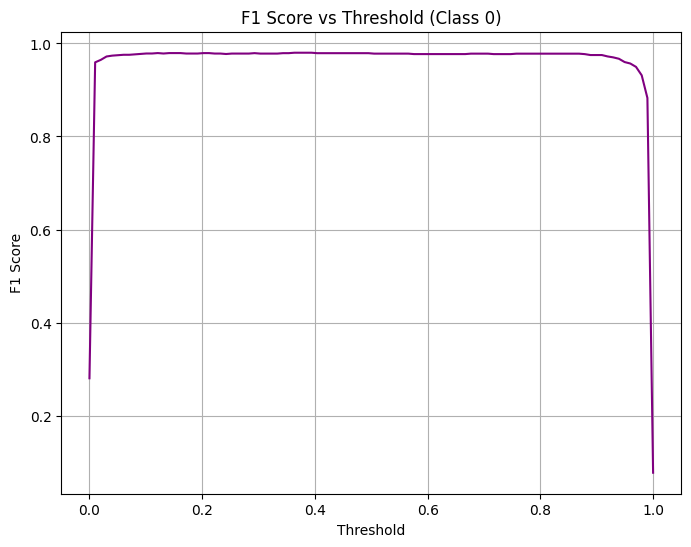

In [42]:
from sklearn.metrics import f1_score

thresholds = np.linspace(0, 1, 100)
f1s = []

for thresh in thresholds:
    preds_thresh = (y_pred_probs[:, 0] >= thresh).astype(int)
    f1 = f1_score(y_true_binarized[:, 0], preds_thresh)
    f1s.append(f1)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1s, color='purple')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold (Class 0)')
plt.grid(True)
plt.savefig("../results/metrices/Custon_CNN_f1_score_vs_threshold_class_0.png")
plt.show()